In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import zero_one_loss
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import binom, beta

In [ ]:
#same as in maltes code can be taken away for the report.
def read_abalone_data() -> pd.DataFrame:
    column_names = [
        "sex",
        "length",
        "diameter",
        "height",
        "whole_weight",
        "shucked_weight",
        "viscera_weight",
        "shell_weight",
        "rings"
    ] 
    df = pd.read_csv(r"C:\Users\U436576\OneDrive - Danfoss\Desktop\DTU\abalone\abalone.data", names=column_names)
    return df

def preproces_data(df: pd.DataFrame) -> pd.DataFrame:
    initial_dataframe_length = len(df)
    df = df[df['height'] != 0]
    df = df[df['height'] < 0.4]
    df = df[(df["whole_weight"] - df["shucked_weight"] - df["viscera_weight"] - df["shell_weight"]) > 0]  
    print(f"removed {initial_dataframe_length - len(df)} data points")
    return df

def get_data():
    df = read_abalone_data()
    df = preproces_data(df)


    y_regression = df["rings"]
    y_classification = df["rings"].apply(
        lambda rings: "young" if rings <= 8 else ("medium" if rings <= 10 else "old")
    )
    X = df.drop(columns=["rings"])
    # One-hot encode sex variable
    X = pd.get_dummies(X, columns=['sex'])

    return X, y_regression, y_classification


In [18]:
X_df, y_regression, y_class = get_data()

X = X_df.to_numpy()
le = LabelEncoder()
y = le.fit_transform(y_class)   # classes as 0,1,2
print("Classes:", le.classes_)  

removed 161 data points
Classes: ['medium' 'old' 'young']


In [ ]:
#test to check what values to use


h_values = [5, 7, 9, 11, 15, 20, 25, 30, 35, 40, 45]
pilot_errors = []

cv_pilot = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for h in h_values:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("ann", MLPClassifier(
            hidden_layer_sizes=(h,),
            activation='relu',
            solver='adam',
            alpha=1e-3,
            max_iter=1000,
            random_state=1
        ))
    ])


    acc = cross_val_score(clf, X, y, cv=cv_pilot, scoring='accuracy').mean()
    err = 1.0 - acc
    pilot_errors.append(err)
    print(f"h={h:2d}, pilot error={err:.3f}")

pilot_results = pd.DataFrame({"h": h_values, "error": pilot_errors})
pilot_results


alpha=1e-05, pilot error=0.336
alpha=1e-04, pilot error=0.335
alpha=1e-03, pilot error=0.336
alpha=1e-02, pilot error=0.335
alpha=1e-01, pilot error=0.336
alpha=1e+00, pilot error=0.343


<Axes: title={'center': 'Pilot error vs log10(alpha) for h=30'}, xlabel='log10_alpha'>

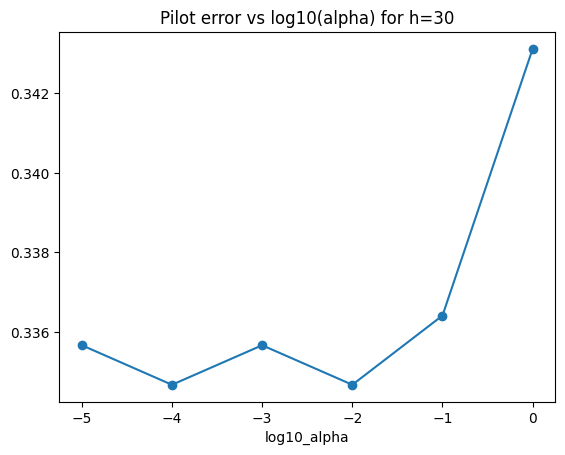

In [ ]:
alpha_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
alpha_errors = []

cv_alpha = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for alpha in alpha_values:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("ann", MLPClassifier(
            hidden_layer_sizes=(30,),
            activation='relu',
            solver='adam',
            alpha=alpha,
            max_iter=1000,
            random_state=1
        ))
    ])

    acc = cross_val_score(clf, X, y, cv=cv_alpha, scoring='accuracy').mean()
    err = 1.0 - acc
    alpha_errors.append(err)
    print(f"alpha={alpha:.0e}, pilot error={err:.3f}")

alpha_results = pd.DataFrame({"alpha": alpha_values, "error": alpha_errors})
alpha_results["log10_alpha"] = np.log10(alpha_results["alpha"])
alpha_results.plot(x="log10_alpha", y="error", marker="o", legend=False,
                   title="Pilot error vs log10(alpha) for h=30")


we dont need to report this test run
but we can see for hidden units that around 11-30 are the best but not really that much change overall.
For the alpha at 1 it is clearly worse as it jumps quite high. between -5 to -1 not that much difference at all so we will go with the middle option of -3. the np.lpgspace covers weak moderate and strong regularization which ensures that the inner cross-validation can identify a suitable complexity level for each of the outer fold, very standard thing to do, from chapter 8 

In [19]:
K_outer = 10
outer_cv = StratifiedKFold(n_splits=K_outer, shuffle=True, random_state=42)

K_inner = 10
lambda_values = np.logspace(-4, 1, 6)
hidden_units_grid = [11, 15, 20, 30]
lambda_ann = 1e-3

In [ ]:
outer_indices = []
best_lambda_list = []
E_test_logreg_list = []
best_h_list = []
E_test_ann_list = []
E_test_baseline_list = []

# storage for later
N = X.shape[0]
y_hat_logreg = np.zeros(N, dtype=int)
y_hat_ann = np.zeros(N, dtype=int)
y_hat_baseline = np.zeros(N, dtype=int)


def standardize_train_test(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

fold_id = 0

for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    print(f"Outer fold {outer_fold}/{K_outer}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Baseline
    baseline_clf = DummyClassifier(strategy='most_frequent')
    baseline_clf.fit(X_train, y_train)
    y_test_baseline = baseline_clf.predict(X_test)
    E_test_baseline = zero_one_loss(y_test, y_test_baseline)
    E_test_baseline_list.append(E_test_baseline)
    y_hat_baseline[test_idx] = y_test_baseline

    #logistic regression
    inner_cv = StratifiedKFold(n_splits=K_inner, shuffle=True, random_state=outer_fold)

    mean_val_errors_logreg = []

    for lam in lambda_values:
        C = 1.0 / lam
        val_errors = []

        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]

            
            X_inner_train_scaled, X_inner_val_scaled, _ = standardize_train_test(
                X_inner_train, X_inner_val
            )

            logreg = LogisticRegression(
                penalty='l2',
                C=C,
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=1000
            )
            logreg.fit(X_inner_train_scaled, y_inner_train)
            y_val_pred = logreg.predict(X_inner_val_scaled)
            val_errors.append(zero_one_loss(y_inner_val, y_val_pred))

        mean_val_errors_logreg.append(np.mean(val_errors))

    best_lambda = lambda_values[np.argmin(mean_val_errors_logreg)]
    best_lambda_list.append(best_lambda)

    X_train_scaled, X_test_scaled, scaler_outer = standardize_train_test(X_train, X_test)

    best_logreg = LogisticRegression(
        penalty='l2',
        C=1.0 / best_lambda,
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000
    )
    best_logreg.fit(X_train_scaled, y_train)
    y_test_logreg = best_logreg.predict(X_test_scaled)
    E_test_logreg = zero_one_loss(y_test, y_test_logreg)
    E_test_logreg_list.append(E_test_logreg)
    y_hat_logreg[test_idx] = y_test_logreg

    #ANN
    mean_val_errors_ann = []

    for h in hidden_units_grid:
        val_errors = []

        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]

            X_inner_train_scaled, X_inner_val_scaled, _ = standardize_train_test(
                X_inner_train, X_inner_val
            )

            ann = MLPClassifier(
                hidden_layer_sizes=(h,),
                activation='relu',
                solver='adam',
                alpha=lambda_ann,
                max_iter=1000,
                random_state=1
            )
            ann.fit(X_inner_train_scaled, y_inner_train)
            y_val_pred = ann.predict(X_inner_val_scaled)
            val_errors.append(zero_one_loss(y_inner_val, y_val_pred))

        mean_val_errors_ann.append(np.mean(val_errors))

    best_h = hidden_units_grid[np.argmin(mean_val_errors_ann)]
    best_h_list.append(best_h)

    best_ann = MLPClassifier(
        hidden_layer_sizes=(best_h,),
        activation='relu',
        solver='adam',
        alpha=lambda_ann,
        max_iter=1000,
        random_state=1
    )
    best_ann.fit(X_train_scaled, y_train)
    y_test_ann = best_ann.predict(X_test_scaled)
    E_test_ann = zero_one_loss(y_test, y_test_ann)
    E_test_ann_list.append(E_test_ann)
    y_hat_ann[test_idx] = y_test_ann

    outer_indices.append(outer_fold)
    fold_id += 1


In [21]:
results_table = pd.DataFrame({
    "outer_fold": outer_indices,
    "h*_i (ANN)": best_h_list,
    "E_test_i (ANN)": E_test_ann_list,
    "lambda*_i (logreg)": best_lambda_list,
    "E_test_i (logreg)": E_test_logreg_list,
    "E_test_i (baseline)": E_test_baseline_list
})

results_table

,outer_fold,h*_i (ANN),E_test_i (ANN),lambda*_i (logreg),E_test_i (logreg),E_test_i (baseline)
0,1,11,0.335821,0.0001,0.333333,0.644279
1,2,30,0.358209,1.0000,0.338308,0.644279
2,3,30,0.373134,0.1000,0.390547,0.646766
3,4,11,0.315920,0.1000,0.320896,0.646766
4,5,20,0.375622,1.0000,0.345771,0.646766
5,6,30,0.325871,0.0010,0.335821,0.646766
6,7,11,0.344140,0.0010,0.354115,0.645885
7,8,20,0.314214,1.0000,0.324190,0.645885
8,9,20,0.324190,0.0001,0.349127,0.645885
9,10,11,0.326683,0.0010,0.334165,0.645885


In [22]:
#mean error rates
results_table.mean(numeric_only=True)

outer_fold              5.500000
h*_i (ANN)             19.400000
E_test_i (ANN)          0.339380
lambda*_i (logreg)      0.320320
E_test_i (logreg)       0.342627
E_test_i (baseline)     0.645916
dtype: float64

### regression, baseline and ANN results comments / thoughts
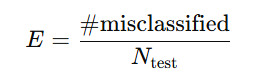 the error rate on the outer test set for ANN in a specific fold. so for example in fold 1 around 33.6% are missclassified, therefore there is 66.4% accruacy in this fold. 


Between the ANN and logistic regression, their mean errors are very close:
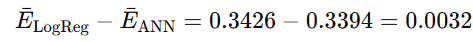

which is less than 0.4 percentage points of accuracy.
At this stage we cannot conclude that the ANN is clearly superior based solely on these averages... 

The baseline model, which always predicts the majority class, performs far worse—achieving only about 35 % accuracy which confirms:
that the classification problem is non-trivial, and that the measured physical features of the abalone shells provide strong predictive signal about age!!

In [ ]:
#task 4
def mcnemar_test(y_true, y_pred_A, y_pred_B, alpha=0.05):
#McNemar test following Method 11.3.2

    y_true = np.asarray(y_true)
    y_pred_A = np.asarray(y_pred_A)
    y_pred_B = np.asarray(y_pred_B)

    correct_A = (y_pred_A == y_true)
    correct_B = (y_pred_B == y_true)

    n11 = np.sum(correct_A &  correct_B)
    n12 = np.sum(correct_A & ~correct_B)
    n21 = np.sum(~correct_A & correct_B)
    n22 = np.sum(~correct_A & ~correct_B)

    n = n11 + n12 + n21 + n22
    assert n == len(y_true)
    theta_hat = (n12 - n21) / n
    s = n12 + n21
    m = min(n12, n21)
    p_value = 2 * binom.cdf(m, s, 0.5)
    if s >= 5:
        E_theta = theta_hat
        Q = (n**2 * (n + 1) * (E_theta + 1) * (1 - E_theta)) / (
            n * s - (n12 - n21)**2
        )
        f = (E_theta + 1) / 2 * (Q - 1)
        g = (1 - E_theta) / 2 * (Q - 1)

        theta_L_prime = beta.ppf(alpha/2, f, g)
        theta_U_prime = beta.ppf(1 - alpha/2, f, g)

        ci_L = 2 * theta_L_prime - 1
        ci_U = 2 * theta_U_prime - 1
    else:
        ci_L, ci_U = np.nan, np.nan

    return {
        "n11": n11, "n12": n12, "n21": n21, "n22": n22,
        "theta_hat": theta_hat,
        "p_value": p_value,
        "ci": (ci_L, ci_U)
    }

res_ann_vs_logreg    = mcnemar_test(y, y_hat_ann,      y_hat_logreg)
res_ann_vs_baseline  = mcnemar_test(y, y_hat_ann,      y_hat_baseline)
res_log_vs_baseline  = mcnemar_test(y, y_hat_logreg,   y_hat_baseline)

res_ann_vs_logreg, res_ann_vs_baseline, res_log_vs_baseline


({'n11': np.int64(2358),
  'n12': np.int64(295),
  'n21': np.int64(282),
  'n22': np.int64(1081),
  'theta_hat': np.float64(0.0032370517928286854),
  'p_value': np.float64(0.617418587093709),
  'ci': (np.float64(-0.008484287846024063), np.float64(0.014957952800654484))},
 {'n11': np.int64(993),
  'n12': np.int64(1660),
  'n21': np.int64(429),
  'n22': np.int64(934),
  'theta_hat': np.float64(0.3065239043824701),
  'p_value': np.float64(3.641484900374412e-170),
  'ci': (np.float64(0.2862676957873629), np.float64(0.32664410255506393))},
 {'n11': np.int64(953),
  'n12': np.int64(1687),
  'n21': np.int64(469),
  'n22': np.int64(907),
  'theta_hat': np.float64(0.30328685258964144),
  'p_value': np.float64(1.4573832666089182e-160),
  'ci': (np.float64(0.28259145950763775), np.float64(0.32384208532235714))})

In [24]:
#look nice
rows = []
pairs = [
    ("ANN", "LogReg",    res_ann_vs_logreg),
    ("ANN", "Baseline",  res_ann_vs_baseline),
    ("LogReg", "Baseline", res_log_vs_baseline),
]

for A, B, res in pairs:
    rows.append({
        "Model A": A,
        "Model B": B,
        "n12 (A correct, B wrong)": res["n12"],
        "n21 (A wrong, B correct)": res["n21"],
        "theta_hat (Δ accuracy)": res["theta_hat"],
        "CI_low": res["ci"][0],
        "CI_high": res["ci"][1],
        "p_value": res["p_value"],
    })

mcnemar_table = pd.DataFrame(rows)
mcnemar_table


,Model A,Model B,"n12 (A correct, B wrong)","n21 (A wrong, B correct)",theta_hat (Δ accuracy),CI_low,CI_high,p_value
0,ANN,LogReg,295,282,0.003237,-0.008484,0.014958,6.174186e-01
1,ANN,Baseline,1660,429,0.306524,0.286268,0.326644,3.641485e-170
2,LogReg,Baseline,1687,469,0.303287,0.282591,0.323842,1.457383e-160


#### McNemar’s test results

For each pair of models we computed the McNemar contingency table

\[
\begin{array}{c|cc}
 & \text{B correct} & \text{B wrong} \\
\hline
\text{A correct} & n_{11} & n_{12} \\
\text{A wrong}   & n_{21} & n_{22}
\end{array}
\]

where \(n_{12}\) counts observations where model A is correct and model B is wrong, and
\(n_{21}\) counts the opposite case...

### Task 5


In [ ]:
#task 5
lambda_final = 0.1
C_final = 1.0 / lambda_final

logreg_final = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        C=C_final,
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        random_state=0
    ))
])


logreg_final.fit(X_df, y)
logreg_model = logreg_final.named_steps["logreg"]


coef_matrix = logreg_model.coef_
intercepts = logreg_model.intercept_


coef_df = pd.DataFrame(
    coef_matrix,
    columns=X_df.columns,
    index=le.classes_
)

print("Intercepts (per class):")
for cls, b in zip(le.classes_, intercepts):
    print(f"  {cls:7s}: {b:.3f}")

print("\nCoefficient matrix (rows = classes, columns = features):")
coef_df


Intercepts (per class):
  medium : 0.355
  old    : 0.229
  young  : -0.584

Coefficient matrix (rows = classes, columns = features):


c:\Users\U436576\dtu02452\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
medium,0.396408,0.030258,0.099288,-1.337730,0.491216,0.240682,0.568257,0.038229,-0.080142,0.040029
old,-0.576978,0.217678,0.335364,3.280107,-2.793890,-0.543670,1.106659,0.061826,-0.118630,0.054201
young,0.180570,-0.247936,-0.434652,-1.942377,2.302674,0.302988,-1.674916,-0.100055,0.198772,-0.094230
